In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import gc

# 1. Load Dataset

In [ ]:
df = pd.read_csv("url_dataset_balanced.csv")   # columns: url, label

print("Dataset shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())

Dataset shape: (7087812, 3)
Label distribution:
 label
0.0    3543906
1.0    3543906
Name: count, dtype: int64


# 2. Feature Extraction Function

In [ ]:
def extract_features(url):
    return {
        "url_length": len(url),
        "num_digits": sum(c.isdigit() for c in url),
        "num_letters": sum(c.isalpha() for c in url),
        "num_special": sum(not c.isalnum() for c in url),
        "count_dot": url.count('.'),
        "count_dash": url.count('-'),
        "count_slash": url.count('/'),
        "count_at": url.count('@'),
        "count_qmark": url.count('?'),
        "count_percent": url.count('%'),
        "count_equal": url.count('='),
        "has_https": int("https" in url.lower()),
        "has_ip": int(url.split("//")[-1].split("/")[0].replace(".", "").isdigit())
    }

# 3. Apply Feature Extraction

In [ ]:
features = df["url"].apply(extract_features)
X = pd.DataFrame(list(features))
y = df["label"].astype("int8")

# Free memory
del df, features
gc.collect()


0

# 4. Optimize Memory (Downcasting)

In [ ]:
for col in X.columns:
    if X[col].max() < 128:
        X[col] = X[col].astype("int8")
    elif X[col].max() < 32768:
        X[col] = X[col].astype("int16")
    else:
        X[col] = X[col].astype("int32")

print("Memory usage after optimization:", X.memory_usage().sum() / 1024**2, "MB")

Memory usage after optimization: 155.46780395507812 MB


# 5. Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Prepare LightGBM Dataset

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 7. LightGBM Parameters

In [ ]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "device": "cpu",   # use "cpu" if GPU not available
    "verbosity": -1
}

# 8. Train Model

In [ ]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=100)]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.259207	valid_1's binary_logloss: 0.261649


# 9. Evaluate Model

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, model.predict(X_test)))


Accuracy: 0.8883132530970405

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89    708782
           1       0.87      0.91      0.89    708781

    accuracy                           0.89   1417563
   macro avg       0.89      0.89      0.89   1417563
weighted avg       0.89      0.89      0.89   1417563


Confusion Matrix:
 [[613361  95421]
 [ 62902 645879]]

ROC-AUC Score: 0.9570023339024443


# visualization

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import numpy as np

# 1. Confusion Matrix Heatmap

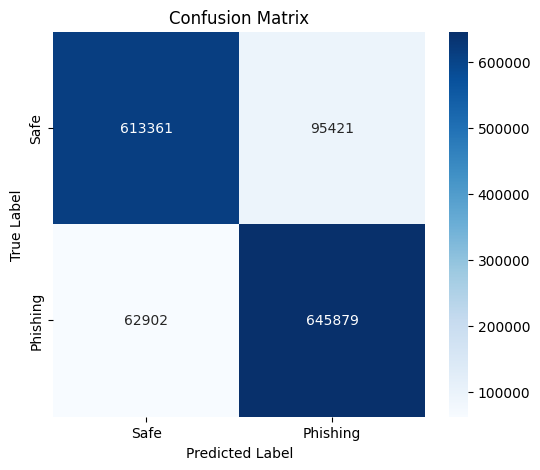

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe", "Phishing"], yticklabels=["Safe", "Phishing"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# 2. ROC Curve

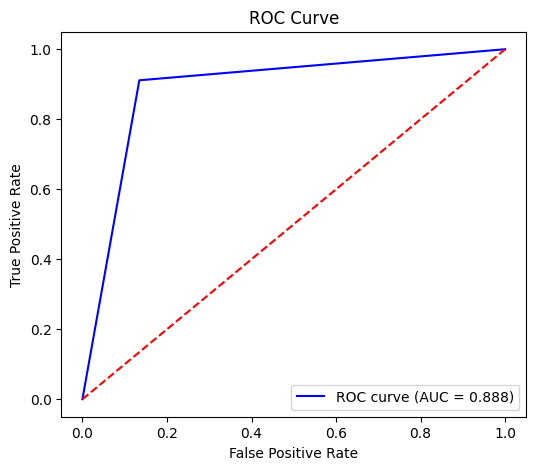

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 3. Precision-Recall Curve

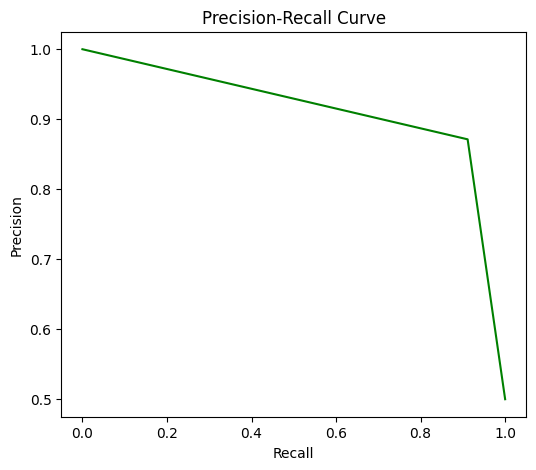

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# 4. Feature Importance (LightGBM)

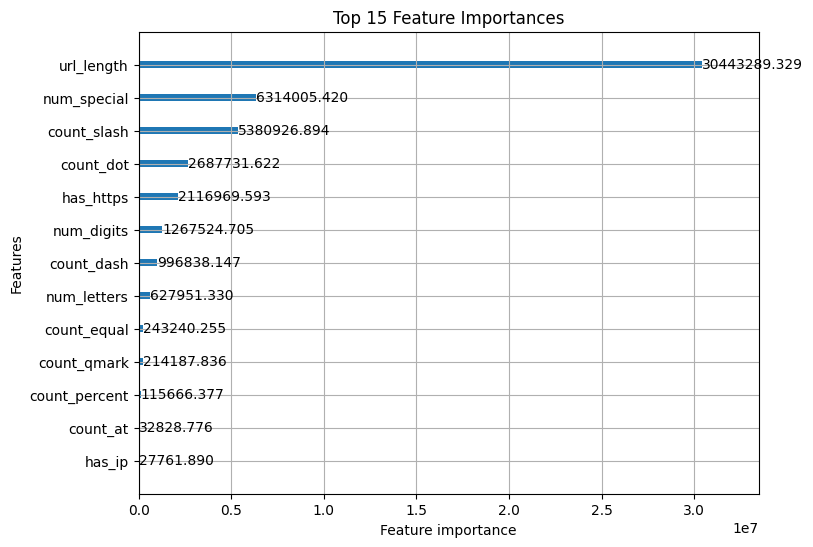

In [19]:
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(8,6))
plt.title("Top 15 Feature Importances")
plt.show()

# 5. Class Balance

/tmp/ipython-input-2744726182.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set2")


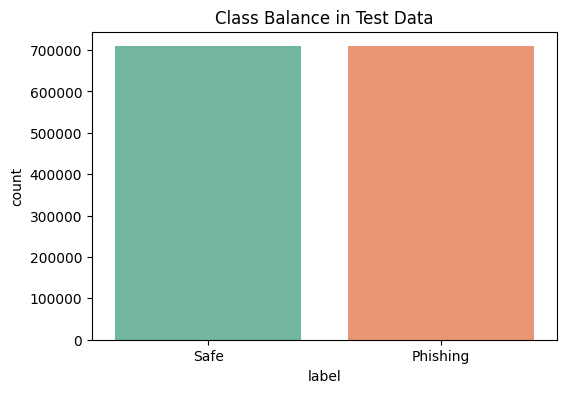

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_test, palette="Set2")
plt.xticks([0,1], ["Safe", "Phishing"])
plt.title("Class Balance in Test Data")
plt.show()

In [ ]:
!pip install requests tldextract python-whois


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pandas as pd

In [42]:
def extract_features(url):
    return {
        "url_length": len(url),
        "num_digits": sum(c.isdigit() for c in url),
        "num_letters": sum(c.isalpha() for c in url),
        "num_special": sum(not c.isalnum() for c in url),
        "count_dot": url.count('.'),
        "count_dash": url.count('-'),
        "count_slash": url.count('/'),
        "count_at": url.count('@'),
        "count_qmark": url.count('?'),
        "count_percent": url.count('%'),
        "count_equal": url.count('='),
        "has_https": int("https" in url.lower()),
        "has_ip": int(url.split("//")[-1].split("/")[0].replace(".", "").isdigit())
    }

def extract_features_vector(url):
    features = extract_features(url)
    return np.array(list(features.values())).reshape(1, -1)

# --- Prediction function ---
def predict_url(url, model):
    X = extract_features_vector(url)
    proba = model.predict(X, num_iteration=model.best_iteration)[0]
    label = int(proba > 0.5)

    if label == 0:
        return "✅ SAFE"
    else:
        return "🚨 NOT SAFE (Phishing)"



# ------------------------
# 🔹 Test your model here:
# ------------------------
test_url = "http://sapref.com"

predict_url(test_url, model)

'✅ SAFE'